# First try

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def compute_gradient_component(x, return_matrix, index):
    # R --> (N periods) x (N assets)
    n_periods = return_matrix.shape[0]
    n_assets = return_matrix.shape[1]

    # derive the derivative manually -->
    # here we calculate the formula for the derivative
    # with respect to component x[index]
    res = 0
    for i in range(n_periods):
        r_i = return_matrix[i]
        
        assert len(r_i) == len(x)
        assert len(r_i) == n_assets

        dot_prod = np.dot(r_i, x)
        eps_emergency = 0

        if dot_prod == 0:
            print(f'Zero dot product in compute_gradient_component!!!')
            eps_emergency = 0.001 

        res += (1 / (np.dot(r_i, x) + eps_emergency)) * r_i[index]
    return -res


def compute_gradient(x, return_matrix):
    x_size = x.shape[0]
    res = []
    # For each component of vector "x"
    # calculate gradient
    for i in range(x_size):
        res.append(compute_gradient_component(x, return_matrix, i))
    return np.array(res)
    

def satisfies_stopping_condition(x):
    return False  # Dont know how to implement yet


def calculate_objective(x, return_matrix):
    n_periods = return_matrix.shape[0]
    # n_assets = return_matrix.shape[1]

    ln_dot_products = []
    for i in range(n_periods):
        r_i = return_matrix[i]
        assert(len(r_i) == len(x))

        dot_product = np.dot(r_i, x)
        eps_emergency = 0
        if dot_product == 0:
            print(f'Dot product in objective func == 0! (log() bad!)')
            eps_emergency = 0.001
        ln_dot_products.append(np.log(dot_product + eps_emergency))
    return -np.sum(ln_dot_products)

In [9]:
def frank_wolfe(return_matrix, n_iterations):
    # n_periods = return_matrix.shape[0]
    n_assets = return_matrix.shape[1]
    
    
    # Our solution is a vector x, |x| = n_assets - 
    # investment distribution
    # We pick initial approximation for x - any
    # simplex vertex
    vertex_to_start = 1
    assert vertex_to_start < n_assets, print('Pick another initial approximation')
    x = np.zeros(n_assets)
    x[vertex_to_start] = 1  # initial approximation - all money to one asset

    objective_values = [calculate_objective(x, return_matrix)]  # objective function

    for k in range(1, n_iterations + 1):
        
        # Compute gradient of objective function
        grad_vector = compute_gradient(x, return_matrix)
        assert(grad_vector.shape[0] == len(x))

        # FW for simplex problem --> minimum of linear
        # function will be reached on the vertex of the simplex
        # Here we search for index with minimum gradient
        # component
        min_index = np.argmin(grad_vector)
        assert grad_vector[min_index] <= 0, print(f'Minimum of gradient vector is positive')
        
        # x_k^ = e_ik from lectures - direction where to go
        xk_hat = np.zeros(n_assets)
        assert(len(xk_hat) == len(grad_vector))
        xk_hat[min_index] = 1

        if satisfies_stopping_condition(xk_hat):
            print(f'Satisfied exiting condition')
            break
        else:
            learning_rate = 2 / (k + 1)
            x = x + learning_rate * (xk_hat - x)
            obj = calculate_objective(x, return_matrix)
            print(f'Iteration {k}: Objective = {obj}')
            objective_values.append(obj)  # objective function

    print(f'Reached limit of iterations')
    assert abs(sum(x) - 1.0) < 0.0001, print(f'Sum of distribution  = {sum(x)} != 1 (100%)!')  # that sum of distribution is 100%
    
    return x, objective_values

def plot_return_matrix(return_matrix, x_lim, assets):
    fig, ax = plt.subplots()

    for asset in assets:
        ax.plot(return_matrix[:x_lim, asset], marker = 'o', markerfacecolor = 'white')

    plt.ylim([0, 1.5])
    plt.xlabel('Period 1 .. T')
    plt.title(f'First {x_lim} samples for {len(assets)} assets')
    plt.ylabel('Return')
    plt.legend([f'Asset {n}' for n in assets])
    plt.grid()

def plot_objective_function(values):
    fig, ax = plt.subplots()

    ax.plot(values, marker = 'o', markerfacecolor = 'white')
    plt.xlabel('Number of iteration')
    plt.ylabel('Objective function')
    plt.title('Objective function')
    plt.grid()


def run_experiment(n_assets, n_periods, max_iterations):
    mean = 0  # like in paper
    var = 0.1  # like in paper

    # Create return matrix as in the paper
    # (N periods) x (N assets) matrix
    return_matrix = np.ones((n_periods, n_assets)) + np.random.normal(loc = mean, scale = var, size = (n_periods, n_assets))
    assert(return_matrix.shape == (n_periods, n_assets))
    assert(len(return_matrix[:, 0]) == n_periods)
    assert(len(return_matrix[0, :]) == n_assets)

    plot_return_matrix(return_matrix, x_lim = 100, assets = [0, 1, 2])

    investment_distribution, objective_func = frank_wolfe(
        return_matrix = return_matrix,
        n_iterations = max_iterations
    )

    plot_objective_function(objective_func)

    return investment_distribution, objective_func

Iteration 1: Objective = -2.252251579494119
Iteration 2: Objective = -2.5437482729321563
Iteration 3: Objective = -2.6257081053280293
Iteration 4: Objective = -2.5269718587697714
Iteration 5: Objective = -2.5810070316572613
Iteration 6: Objective = -2.6402762241918896
Reached limit of iterations


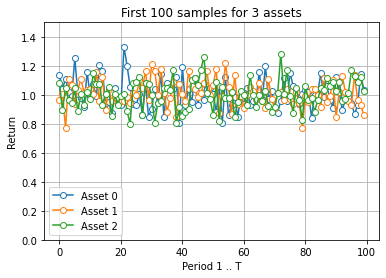

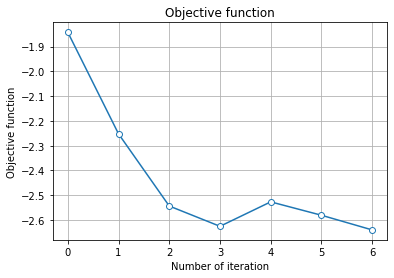

In [10]:
investments, objective_func = run_experiment(
    n_assets = 100, 
    n_periods = 200, 
    max_iterations = 6
)

Iteration 1: Objective = -3.774282049075763
Iteration 2: Objective = -4.08951547076345
Iteration 3: Objective = -4.0078825990782665
Iteration 4: Objective = -4.216868893489661
Iteration 5: Objective = -4.2295520359396495
Iteration 6: Objective = -4.26817303224978
Iteration 7: Objective = -4.2541613237210925
Iteration 8: Objective = -4.242262591003835
Reached limit of iterations


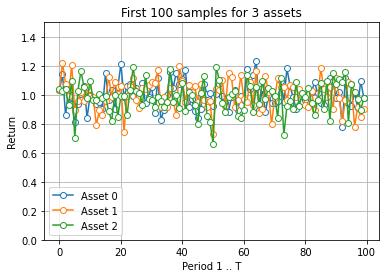

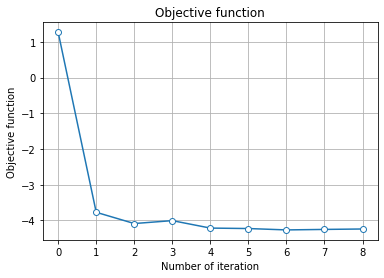

In [11]:
investments, objective_func = run_experiment(
    n_assets = 400, 
    n_periods = 250, 
    max_iterations = 8
)

In [15]:
investments[investments != 0.0]

array([0.30555556, 0.41666667, 0.19444444, 0.08333333])